# Plot storage

In [29]:
import logging
logging.basicConfig(level=logging.ERROR)


import pypsa

import pandas as pd
from pyomo.environ import Constraint

import matplotlib.pyplot as plt

import json

import xarray as xr

%matplotlib inline

In [2]:
weather_dir = "/home/tom/energy/playground/whobs-server/data/"

#read in renewables.ninja solar time series                                                                                                              
solar_pu = xr.open_dataset(weather_dir + 'ninja_pv_europe_v1.1_sarah.nc')

#read in renewables.ninja wind time series                                                                                                               
wind_pu = xr.open_dataset(weather_dir + 'ninja_wind_europe_v1.1_current_on-offshore.nc')


def annuity(lifetime,rate):
    if rate == 0.:
        return 1/lifetime
    else:
        return rate/(1. - 1. / (1. + rate)**lifetime)

In [3]:
assumptions_df = pd.DataFrame(columns=["FOM","fixed","discount rate","lifetime","investment","efficiency"],
                              index=["wind","solar","hydrogen_electrolyser","hydrogen_turbine","hydrogen_energy",
                                     "battery_power","battery_energy"],
                              dtype=float)

assumptions_df["lifetime"] = 25.
assumptions_df.at["hydrogen_electrolyser","lifetime"] = 20.
assumptions_df.at["battery_power","lifetime"] = 15.
assumptions_df.at["battery_energy","lifetime"] = 15.
assumptions_df["discount rate"] = 0.05
assumptions_df["FOM"] = 3.
assumptions_df["efficiency"] = 1.
assumptions_df.at["battery_power","efficiency"] = 0.9

In [49]:
assumptions = {"wind" : True,
               "solar" : False,
               "battery" : False,
               "hydrogen" : True,
               "load" : 100,
               "wind_cost": 1182,
               "solar_cost" : 600,
               "battery_energy_cost" : 100,
               "battery_power_cost" : 100,
               "hydrogen_electrolyser_cost" : 750,
          "hydrogen_energy_cost" : 0.5,
          "hydrogen_electrolyser_efficiency" : 80,
          "hydrogen_turbine_cost" : 800,
          "hydrogen_turbine_efficiency" : 60,
          "discount_rate" : 0.05,
               "frequency" : 3,
               "year" : 2011,
               "country" : "DE"}

In [50]:
booleans = ["wind","solar","battery","hydrogen"]

floats = ["load","wind_cost","solar_cost","battery_energy_cost",
          "battery_power_cost","hydrogen_electrolyser_cost",
          "hydrogen_energy_cost",
          "hydrogen_electrolyser_efficiency",
          "hydrogen_turbine_cost",
          "hydrogen_turbine_efficiency",
          "discount_rate"]

threshold = 0.1

def error(message, jobid):
    with open('results-solve/results-{}.json'.format(jobid), 'w') as fp:
        json.dump({"jobid" : jobid,
                   "status" : "Error",
                   "error" : message
                   },fp)
    print("Error: {}".format(message))
    return {"error" : message}

def solve(assumptions):


    for key in booleans:
        try:
            assumptions[key] = bool(assumptions[key])
        except:
            return error("{} could not be converted to boolean".format(key), jobid)

    for key in floats:
        try:
            assumptions[key] = float(assumptions[key])
        except:
            return error("{} could not be converted to float".format(key), jobid)

        if assumptions[key] < 0 or assumptions[key] > 1e5:
            return error("{} {} was not in the valid range [0,1e5]".format(key,assumptions[key]), jobid)


    print(assumptions)
    ct = assumptions['country']
    if ct not in solar_pu or ct+"_ON" not in wind_pu:
        return error("Country {} not found among valid countries".format(ct), jobid)

    try:
        year = int(assumptions['year'])
    except:
        return error("Year {} could not be converted to an integer".format(assumptions['year']), jobid)

    if year < 1985 or year > 2015:
        return error("Year {} not in valid range".format(year), jobid)

    year_start = year
    year_end = year

    Nyears = year_end - year_start + 1

    try:
        frequency = int(assumptions['frequency'])
    except:
        return error("Frequency {} could not be converted to an int".format(assumptions["frequency"]), jobid)

    if frequency < 1 or frequency > 8760:
        return error("Frequency {} is not in the valid range [1,8760]".format(frequency), jobid)


    assumptions_df["discount rate"] = assumptions["discount_rate"]/100.

    for item in ["wind","solar","battery_energy","battery_power","hydrogen_electrolyser","hydrogen_energy","hydrogen_turbine"]:
        assumptions_df.at[item,"investment"] = assumptions[item + "_cost"]

    for item in ["hydrogen_electrolyser","hydrogen_turbine"]:
        assumptions_df.at[item,"efficiency"] = assumptions[item + "_efficiency"]/100.


    #convert costs from per kW to per MW
    assumptions_df["investment"] *= 1000.
    assumptions_df["fixed"] = [(annuity(v["lifetime"],v["discount rate"])+v["FOM"]/100.)*v["investment"]*Nyears for i,v in assumptions_df.iterrows()]

    print('Starting task for {} with assumptions {}'.format(ct,assumptions_df))

    network = pypsa.Network()

    snapshots = pd.date_range("{}-01-01".format(year_start),"{}-12-31 23:00".format(year_end),
                              freq=str(frequency)+"H")

    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(frequency),index=network.snapshots)

    network.add("Bus",ct)
    network.add("Load",ct,
                bus=ct,
                p_set=assumptions["load"])

    if assumptions["solar"]:
        network.add("Generator",ct+" solar",
                    bus=ct,
                    p_max_pu = solar_pu[ct].to_series(),
                    p_nom_extendable = True,
                    marginal_cost = 0.1, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                    capital_cost = assumptions_df.at['solar','fixed'])

    if assumptions["wind"]:
        network.add("Generator",ct+" wind",
                    bus=ct,
                    p_max_pu = wind_pu[ct+"_ON"].to_series(),
                    p_nom_extendable = True,
                    marginal_cost = 0.2, #Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
                    capital_cost = assumptions_df.at['wind','fixed'])


    if assumptions["battery"]:

        network.add("Bus",ct + " battery")

        network.add("Store",ct + " battery_energy",
                    bus = ct + " battery",
                    e_nom_extendable = True,
                    e_cyclic=True,
                    capital_cost=assumptions_df.at['battery_energy','fixed'])

        network.add("Link",ct + " battery_power",
                    bus0 = ct,
                    bus1 = ct + " battery",
                    efficiency = assumptions_df.at['battery_power','efficiency'],
                    p_nom_extendable = True,
                    capital_cost=assumptions_df.at['battery_power','fixed'])

        network.add("Link",ct + " battery_discharge",
                    bus0 = ct + " battery",
                    bus1 = ct,
                    p_nom_extendable = True,
                    efficiency = assumptions_df.at['battery_power','efficiency'])

        def extra_functionality(network,snapshots):
            def battery(model):
                return model.link_p_nom[ct + " battery_power"] == model.link_p_nom[ct + " battery_discharge"]*network.links.at[ct + " battery_power","efficiency"]

            network.model.battery = Constraint(rule=battery)
    else:
        def extra_functionality(network,snapshots):
            pass

    if assumptions["hydrogen"]:

        network.add("Bus",
                     ct + " hydrogen",
                     carrier="hydrogen")

        network.add("Link",
                    ct + " hydrogen_electrolyser",
                    bus1=ct + " hydrogen",
                    bus0=ct,
                    p_nom_extendable=True,
                    efficiency=assumptions_df.at["hydrogen_electrolyser","efficiency"],
                    capital_cost=assumptions_df.at["hydrogen_electrolyser","fixed"])

        network.add("Link",
                     ct + " hydrogen_turbine",
                     bus0=ct + " hydrogen",
                     bus1=ct,
                     p_nom_extendable=True,
                     efficiency=assumptions_df.at["hydrogen_turbine","efficiency"],
                     capital_cost=assumptions_df.at["hydrogen_turbine","fixed"]*assumptions_df.at["hydrogen_turbine","efficiency"])  #NB: fixed cost is per MWel

        network.add("Store",
                     ct + " hydrogen_energy",
                     bus=ct + " hydrogen",
                     e_nom_extendable=True,
                     e_cyclic=True,
                     capital_cost=assumptions_df.at["hydrogen_energy","fixed"])

    network.consistency_check()


    solver_name = "cbc"
    formulation = "kirchhoff"
    status, termination_condition = network.lopf(solver_name=solver_name,
                                                 formulation=formulation,
                                                 extra_functionality=extra_functionality)

    print(status,termination_condition)
    
    return network

In [51]:
n = solve(assumptions)

{'wind': True, 'solar': False, 'battery': False, 'hydrogen': True, 'load': 100.0, 'wind_cost': 1182.0, 'solar_cost': 600.0, 'battery_energy_cost': 100.0, 'battery_power_cost': 100.0, 'hydrogen_electrolyser_cost': 750.0, 'hydrogen_energy_cost': 0.5, 'hydrogen_electrolyser_efficiency': 80.0, 'hydrogen_turbine_cost': 800.0, 'hydrogen_turbine_efficiency': 60.0, 'discount_rate': 0.05, 'frequency': 3, 'year': 2011, 'country': 'DE'}
Starting task for DE with assumptions                        FOM         fixed  discount rate  lifetime  investment  \
wind                   3.0  83047.934485         0.0005      25.0   1182000.0   
solar                  3.0  42156.311921         0.0005      25.0    600000.0   
hydrogen_electrolyser  3.0  60197.186640         0.0005      20.0    750000.0   
hydrogen_turbine       3.0  56208.415895         0.0005      25.0    800000.0   
hydrogen_energy        3.0     35.130260         0.0005      25.0       500.0   
battery_power          3.0   9693.364437      

In [52]:
n.objective/assumptions["load"]/n.snapshot_weightings.sum()

91.49297640410958

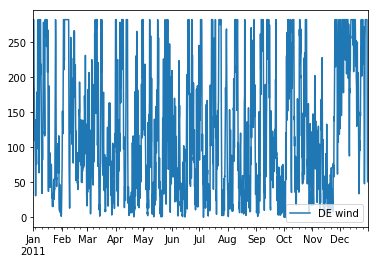

In [53]:
n.generators_t.p.plot()

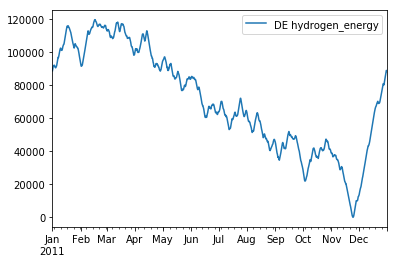

In [54]:
n.stores_t.e.plot()

In [55]:
n.links.p_nom_opt

DE hydrogen_electrolyser    182.53088
DE hydrogen_turbine         166.28452
Name: p_nom_opt, dtype: float64

In [56]:
n.buses_t.marginal_price.mean()

DE             91.492977
DE hydrogen    74.184270
dtype: float64

In [57]:
n.generators.p_nom_opt

DE wind    712.07005
Name: p_nom_opt, dtype: float64

In [58]:
(n.links_t.p0.multiply(n.buses_t.marginal_price[assumptions['country']],axis=0)/n.links_t.p0).mean()

DE hydrogen_electrolyser     43.168275
DE hydrogen_turbine         143.529676
dtype: float64

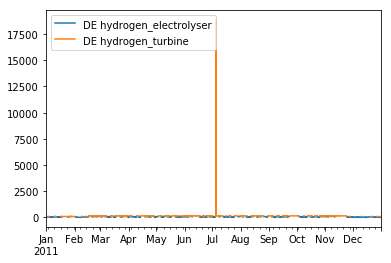

In [59]:
(n.links_t.p0.multiply(n.buses_t.marginal_price[assumptions['country']],axis=0)/n.links_t.p0).plot()

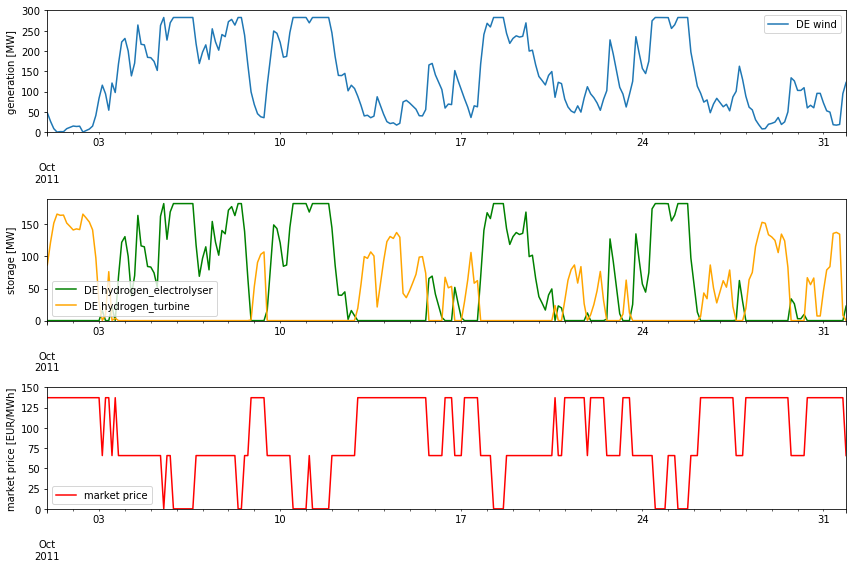

In [77]:
start = "2011-10-01"
end = "2011-10-31"

fig,axes = plt.subplots(3,1)

fig.set_size_inches((12,8))


ax=axes[0]

n.generators_t.p.loc[start:end].plot(ax=ax)

ax.set_ylabel("generation [MW]")

ax.set_ylim([0,300])

ax=axes[1]

n.links_t.p0.loc[start:end].plot(ax=ax,color=["g","orange"])

ax.set_ylabel("storage [MW]")

ax.set_ylim([0,190])

ax=axes[2]

n.buses_t.marginal_price.loc[start:end,assumptions["country"]].plot(ax=ax,label="market price",color="r")

ax.legend()

ax.set_ylabel("market price [EUR/MWh]")

ax.set_ylim([0,150])

fig.tight_layout()

fig.savefig("storage_bids.pdf",transparent=True)